In [1]:
# # For padas to excel file
#!pip install openpyxl

# # pip install required modules
# # uncomment if running from colab
# # see list of modules in `requirements` and `extras`
# # in https://github.com/PyThaiNLP/pythainlp/blob/dev/setup.py

#!pip install pythainlp
#!pip install epitran
#!pip install python-crfsuite
#!pip install demoji

#Currently, not using the following...
#!pip install clean-text
#!pip install wordcloud
#!pip install emoji

In [2]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Training set

In [3]:
status_labeled_file = "data/statuses2022102022_labeled.csv"
train_df= pd.read_csv(status_labeled_file)

In [4]:
train_df.groupby(['label'])['label'].count()

label
0    9926
1     357
Name: label, dtype: int64

# Sample spam tweets

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
print(train_df[train_df['label']==1]['text'].tail(5).to_string(index=False))

               🎀รับพนักงาน หลายอัตราไม่จำกัดอายุจ่ายรายวัน🎀\n✅ แค่มีเน็ตและมือถือก็ทำได้\n✅ ถูกกฏหมาย ไม่ใช่การพนัน\n✅ ไม่จำกัดอายุ งานง่ายรายได้ดี\n#โตโน่ภาคิน #ออฟกัน #peatwasu #ใส่นัวแฟมิลี่ #หุกุ #ENGFA_NationalCostume #บาสเด็กอ้วนที่แท้จริง #LAZ1_1stFansign #KPWorldTourManila https://t.co/4YooeKf4IM
                                                    📢 ใครที่กำลังหาค่าเทอม ค่าขนม  ค่าใช้จ่าย \n👉เชิญทางนี้ค่ะ งานถูกกฎหมาย ไม่มีค่าสมัคร/สอนงานฟรี\n-นกเรียน/นักศึกษา/ว่างงาน🌈\n#หางานออนไลน์ #หางานเสริมทําที่บ้าน #งานพาร์ทไทม์ #LISAXBVLGARI #peatwasu #TXTinBKK #SUHOxMEW #BLACKPINK https://t.co/oUTe1IfHB4
สร้างรายได้ผ่านโทรศัพท์📲\nสวรรค์ของทุกคนที่อยู่ว่างเริ่มขึ้นที่นี่\nใช้เวลาแค่ไม่กี่นาที ง่ายๆได้เงินจริง\nระบบทันสมัยที่สุด ที่มีในประเทศไทย\nรายได้เฉลี่ยวันล่ะ 300-1500 บาท\n✔️งานง่ายได้เงินจริง✅\n#정해인 #JungHaeIn #HAESOO #HAEIN #BLACKPINKWorldTour2022 #LISA #โตโน่ภาคิน #SUHOxMEW https://t.co/JsreZZ9I8s
                                                                                  

# Thai NLP

In [7]:
import pythainlp
from pythainlp import word_tokenize
from pythainlp import sent_tokenize
from pythainlp.util import normalize
from pythainlp.corpus import thai_stopwords
import re
import string
#from cleantext import clean
import demoji

print(pythainlp.__version__)
stop_words= thai_stopwords()
print('stop_words len=', len(stop_words))

3.1.0
stop_words len= 1030


In [8]:
#print(stop_words)

# Extracting top hashtags

In [9]:
from collections import Counter

def get_top_hashtags(df, size):
    counter = Counter()

    for i in range(len(df)):
        text = df.values[i][0]
        regex = "(#\S+)"
        hashtags = re.findall(regex, text)
        for hashtag in hashtags:
            counter[hashtag] += 1
            
    top = sorted(counter, key=counter.get, reverse=True)
    return top[:size]

In [10]:
train_text_df = pd.DataFrame(train_df['text'])
train_label_df = pd.DataFrame(train_df['label'])

In [11]:
train_top_hashtags = get_top_hashtags(train_text_df, 100)
#print(train_top_hashtags)
top_hashtags= train_top_hashtags

# Thai tokenizer
Converting text to word list

In [12]:
# https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
def remove_emojis(text):
    dem = demoji.findall(text)
    for item in dem.keys():
        text = text.replace(item, '')
    return text

def remove_urls(text):
    return re.sub(r'https?:\/\/\S+', '', text, flags=re.MULTILINE)

def remove_hashtags(text):
    return re.sub(r'#\S+', '', text, flags=re.MULTILINE)

def remove_top_hashtags(text, top_hashtags):
    for hashtag in top_hashtags:
         text =re.sub(hashtag, '', text, flags=re.MULTILINE)
    return text

def remove_rt(text):
    return re.sub(r'RT @\S+', '', text, flags=re.MULTILINE)

def remove_mentions(text):
    return re.sub(r'@\S+', '', text, flags=re.MULTILINE)

def remove_newlines(text):
    return re.sub(r'\n', ' ', text, flags=re.MULTILINE)

#from string import digits
remove_digits = str.maketrans('', '', string.digits)
remove_punctuations = str.maketrans('', '', string.punctuation)

#top_hashtags = []
## Remove urls, hashtags, mentions and normalize
def preprocess_text(text):
    #text = deEmojify(text)
    #text = remove_emojies(text)
    text = remove_emojis(text)
    text = remove_urls(text)
    if len(top_hashtags) > 0:
        text = remove_top_hashtags(text, top_hashtags)
    else:
        text = remove_hashtags(text)
        
    text = remove_rt(text)
    text = remove_mentions(text)
    text = remove_newlines(text)
    text = text.translate(remove_punctuations)
    text = text.translate(remove_digits)
    text = normalize(text)
    return text

def th_tokenizer0(text):
    text = preprocess_text(text)
    return word_tokenize(text, keep_whitespace=False)

def th_tokenizer(text):
    text = preprocess_text(text)
    words = word_tokenize(text, keep_whitespace=False)
    tokenized_words = []
    for word in words:
        if not word in stop_words:
            tokenized_words.append(word)
    return tokenized_words


# TFID Vectorizor
Converting each text(tweet) to features vector

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = thai_stopwords()
#vectorizer = TfidfVectorizer(tokenizer=th_word_tokenize, stop_words=stop_words, min_df=2)
vectorizer = TfidfVectorizer(tokenizer=th_tokenizer, min_df=2)
vectorizer.fit(train_text_df['text'])
train_features = vectorizer.transform(train_text_df['text'])
train_features.shape

/Users/mananai/opt/miniconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(10283, 6456)

# Bayes Classifier

In [56]:
#print(vectorizer.vocabulary_)

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

In [15]:
#split the dataset into train and test set
X_train, X_test, y_train, y_test = train_test_split(train_features, train_label_df['label'], test_size=0.15)
print(X_train.shape, X_test.shape)

(8740, 6456) (1543, 6456)


In [16]:
bayes = MultinomialNB(alpha=0.1)
bayes.fit(X_train, y_train)
pred = bayes.predict(X_test)
print("accuracy =", accuracy_score(y_test , pred))
print("precision =", precision_score(y_test , pred))
print("recall =", recall_score(y_test , pred))
print("roc_auc =", roc_auc_score(y_test, pred))

accuracy = 0.9948152948801037
precision = 0.9016393442622951
recall = 0.9649122807017544
roc_auc = 0.9804372978205945


# Real data set
Predicting whether each tweet is a spam or not

In [17]:
#Production file
prd_file = "data/statuses20221027.csv"
prd_df =  pd.read_csv(prd_file)
prd_text_df =  prd_df.loc[prd_df['is_retweet']==0][['text', 'id']]

In [19]:
prd_top_hashtags = get_top_hashtags(prd_text_df, 100)
#print(prd_top_hashtags)
top_hashtags = prd_top_hashtags

In [20]:
prd_features = vectorizer.transform(prd_text_df['text'])
prd_pred = bayes.predict(prd_features)

# Save the prediction result to the CSV file

In [21]:
#Add prediction column
prd_text_df['label']=prd_pred.tolist()
prd_label_df=prd_text_df[['id', 'label']]
#Join the production dataframe with the prediction
prd_result_df = pd.merge(prd_df, prd_label_df, how='left', on = 'id')
prd_result_df['label']=prd_result_df['label'].fillna(0)
#Convert the label to int
prd_result_df['label']=prd_result_df['label'].astype(int)
labeled_file='data/statuses20221027_labeled.csv'
prd_result_df.to_csv(labeled_file, index=False)

In [22]:
prd_result_df.groupby(['label'])['label'].count()

label
0    57447
1      248
Name: label, dtype: int64

# Hyperparameter tuning

In [23]:
def test_bayes(alpha, features, labels):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25)
    bayes = MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    pred = bayes.predict(X_test)
    return [precision_score(y_test , pred), recall_score(y_test, pred), roc_auc_score(y_test, pred)]

In [24]:
[precision, recall, roc_auc]=test_bayes(0.1, train_features, train_label_df['label'])
print("precision=", precision, ",recall=", recall, ", roc_auc=", roc_auc )

precision= 0.8969072164948454 ,recall= 0.9354838709677419 , roc_auc= 0.9657241792288266


In [25]:
import matplotlib.pyplot as plt

In [26]:
def plot_bayes_scores(alphas, features, labels):
    times = 3
    precisions = []
    recalls = []
    roc_aucs = []
    for alpha in alphas:
        
        sum_precisions = 0
        sum_recalls = 0
        sum_roc_aucs = 0
        for i in range(times):
            [precision, recall, roc_auc] = test_bayes(alpha, features, labels)
            sum_precisions += precision
            sum_recalls += recall
            sum_roc_aucs += roc_auc
        
        avg_precision = sum_precisions/times
        avg_recall = sum_recalls/times
        avg_roc_auc = sum_roc_aucs/times
            
        precisions.append(avg_precision)
        recalls.append(avg_recall)
        roc_aucs.append(avg_roc_auc)
        
    plt.plot(alphas, precisions, label="precision")
    plt.plot(alphas, recalls, label="recall")
    plt.plot(alphas, roc_aucs, label="roc_auc")
    plt.legend()
    plt.show()

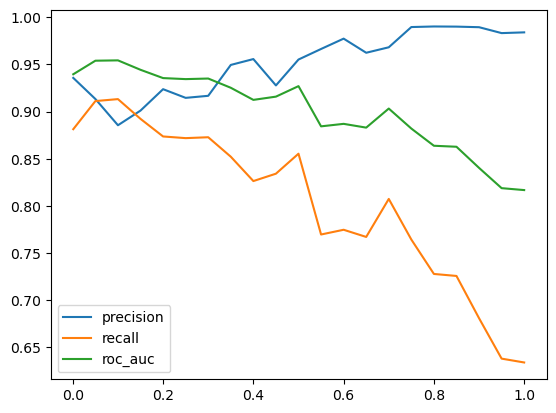

In [27]:
alphas = np.linspace(0.05,1,20)
alphas = np.insert(alphas, 0, 1e-3)
#print(params)
plot_bayes_scores(alphas, train_features, train_label_df['label'])

In [110]:
prd_pred.sum()

238

In [29]:
#prd_result_df.dtypes

In [49]:
prd_result_df[prd_result_df['label']==1]['text'].shape

(245,)

In [28]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [28]:
#prd_result_df[prd_result_df['label']==1]['text']